<a href="https://colab.research.google.com/github/LiYuan199701/TimeSeries/blob/Bayesian-single-perceptron-TS/Bayesian_Single_P_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian single-neuron perceptron for time series (Bayes-by-Backprop)

In [9]:
# Bayesian single-neuron perceptron for time series (Bayes-by-Backprop)
# ---------------------------------------------------------
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150  # Adjust for inline display resolution
plt.rcParams['savefig.dpi'] = 150 # Adjust for saved figure resolution

# Generate Simulated Time Series

Text(0.5, 1.0, 'Bounded Time Series')

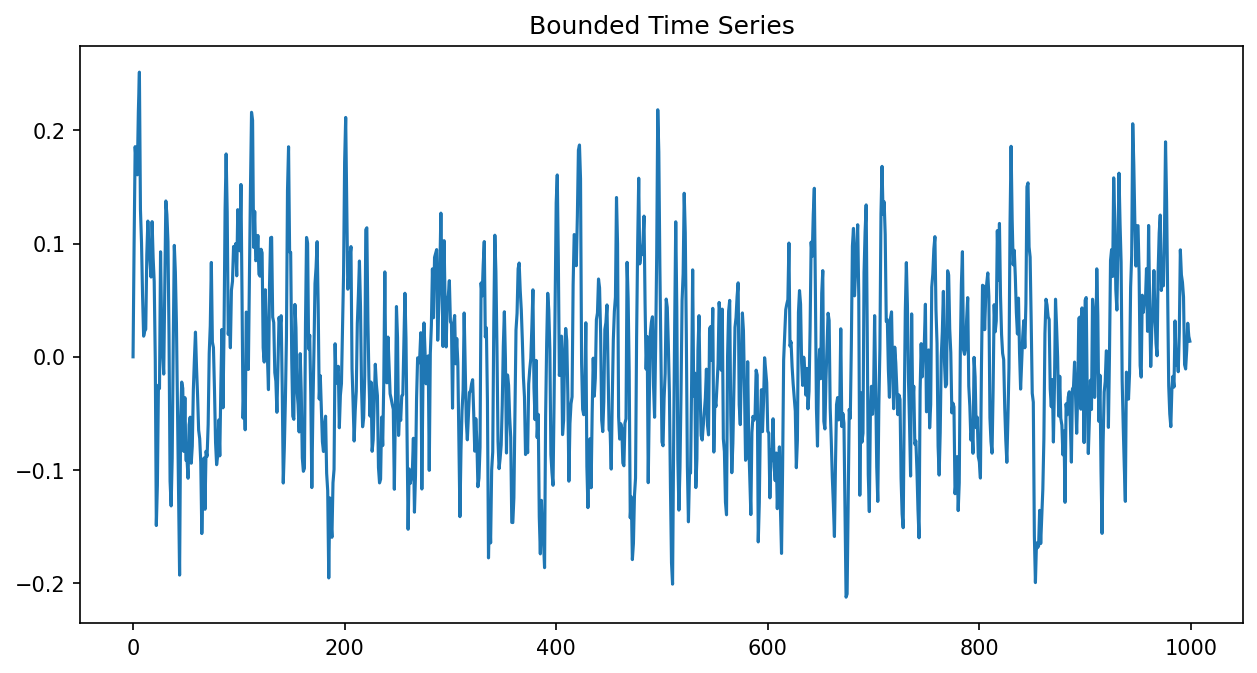

In [10]:
torch.manual_seed(0)
np.random.seed(0)
# -------------------------------
# 1) Simulate bounded time series
# -------------------------------
T = 1000
x = np.zeros(T)
x[0], x[1] = 0.0, 0.1
for t in range(2, T):
    x[t] = 0.7 * x[t-1] - 0.3 * x[t-2] + 0.1 * np.sin(3 * x[t-1]) + 0.05 * np.random.randn()
    x[t] = np.tanh(x[t])  # keep within [-1, 1]

# plot this time series
plt.figure(figsize=(10,5))
plt.plot(x)
plt.title("Bounded Time Series")

# Create lagged time series dataframe and tensor

In [14]:
# -----------------------------------
# 2) Build lag features (past d steps)
# -----------------------------------
def make_lagged(series, d):
    N = len(series) - d
    X = np.zeros((N, d), dtype=np.float32)
    y = np.zeros(N, dtype=np.float32)
    for i in range(N):
        # most recent first: [x_{t-1}, x_{t-2}, ..., x_{t-d}]
        X[i] = series[i:i+d][::-1]
        y[i] = series[i+d]
    return X, y

d = 5
X, y = make_lagged(x, d)
split = int(0.8 * len(y))
X_train, y_train = X[:split], y[:split]
X_test,  y_test  = X[split:], y[split:]

X_train_t = torch.tensor(X_train)
y_train_t = torch.tensor(y_train).unsqueeze(1)
X_test_t  = torch.tensor(X_test)
y_test_t  = torch.tensor(y_test).unsqueeze(1)

# print out X_lag and y
print("X:")
print(X[:2])
print("y:")
print(y[:2])

X:
[[0.16069214 0.17105679 0.18557908 0.1        0.        ]
 [0.2161121  0.16069214 0.17105679 0.18557908 0.1       ]]
y:
[0.2161121  0.25133267]


# Variational Bayes building block: Bayesian linear layer

In [15]:
# ---------------------------------------------------------
# 3) Variational Bayes building block: Bayesian linear layer
# ---------------------------------------------------------
class BayesLinear(nn.Module):
    """
    Variational linear layer with Normal prior N(0, sigma_p^2) and
    factorized Normal posterior q(theta) = N(mu, softplus(rho)^2).
    """
    def __init__(self, in_features, out_features, prior_sigma=1.0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Variational parameters for weights
        self.w_mu   = nn.Parameter(torch.zeros(out_features, in_features))
        self.w_rho  = nn.Parameter(torch.full((out_features, in_features), -3.0))  # small init sigma
        # Variational parameters for bias
        self.b_mu   = nn.Parameter(torch.zeros(out_features))
        self.b_rho  = nn.Parameter(torch.full((out_features,), -3.0))

        # Prior std
        self.prior_sigma = prior_sigma
        self.prior_var   = prior_sigma**2

    def sample_weights(self):
        w_sigma = F.softplus(self.w_rho)  # >0
        b_sigma = F.softplus(self.b_rho)
        eps_w = torch.randn_like(self.w_mu)
        eps_b = torch.randn_like(self.b_mu)
        W = self.w_mu + w_sigma * eps_w
        b = self.b_mu + b_sigma * eps_b
        return W, b, w_sigma, b_sigma

    def kl_divergence(self, w_sigma, b_sigma):
        # KL[q || p] for factorized Gaussians, with p=N(0, prior_sigma^2)
        # KL = 0.5 * [ (sigma_q^2 + mu_q^2)/sigma_p^2 - 1 - log(sigma_q^2/sigma_p^2) ] summed over params
        w_var = w_sigma**2
        b_var = b_sigma**2

        kl_w = 0.5 * (
            (w_var + self.w_mu**2) / self.prior_var
            - 1.0
            - torch.log(w_var / self.prior_var)
        ).sum()

        kl_b = 0.5 * (
            (b_var + self.b_mu**2) / self.prior_var
            - 1.0
            - torch.log(b_var / self.prior_var)
        ).sum()

        return kl_w + kl_b

    def forward(self, x, sample=True):
        if sample:
            W, b, w_sigma, b_sigma = self.sample_weights()
            out = x @ W.t() + b
            kl  = self.kl_divergence(w_sigma, b_sigma)
            return out, kl
        else:
            # Use posterior means (for fast deterministic pass)
            out = x @ self.w_mu.t() + self.b_mu
            kl = torch.tensor(0.0, device=x.device)
            return out, kl

# ----------------------------------------------------
# 4) Bayesian single perceptron: tanh(w^T x + b) output
#    with Gaussian observation noise (learned)
# ----------------------------------------------------
class BayesianSinglePerceptron(nn.Module):
    def __init__(self, d, prior_sigma=0.5):
        super().__init__()
        self.blin = BayesLinear(d, 1, prior_sigma=prior_sigma)
        # Learn observation noise: sigma_eps = softplus(log_sigma_eps)
        self.log_sigma_eps = nn.Parameter(torch.tensor(-2.0))  # start small

    def forward(self, x, sample=True):
        lin_out, kl = self.blin(x, sample=sample)
        y_hat = torch.tanh(lin_out)  # bounded output
        sigma_eps = F.softplus(self.log_sigma_eps) + 1e-6
        return y_hat, sigma_eps, kl

# -----------------------------------------
# 5) ELBO training (Monte Carlo estimator)
# -----------------------------------------
def elbo_step(model, x, y, num_samples=2, beta=1.0):
    """
    num_samples: MC samples for the expectation over q
    beta: KL weight (use KL annealing if desired)
    """
    total_nll = 0.0
    total_kl  = 0.0
    N = x.shape[0]

    for _ in range(num_samples):
        y_hat, sigma_eps, kl = model(x, sample=True)
        # Gaussian NLL (up to additive constant)
        # nll = 0.5 * sum( (y - y_hat)^2 / sigma_eps^2 + 2*log(sigma_eps) )
        nll = 0.5 * (((y - y_hat) ** 2) / (sigma_eps**2) + 2.0 * torch.log(sigma_eps)).sum()
        total_nll += nll
        total_kl  += kl

    # Average over MC samples
    nll = total_nll / num_samples
    kl  = total_kl / num_samples

    # ELBO = -(NLL + beta * KL)
    loss = nll + beta * kl
    # For reporting, compute per-sample MSE-ish term:
    mse_like = ((y - y_hat) ** 2).mean().detach()
    return loss, nll.detach(), kl.detach(), mse_like


# Train

In [17]:
# Instantiate model
model = BayesianSinglePerceptron(d=d, prior_sigma=0.5)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Simple KL annealing schedule (optional but helpful)
epochs = 800
mc_samples = 2
for epoch in range(1, epochs + 1):
    model.train()
    # Cosine anneal beta from 0 -> 1
    beta = 0.5 * (1 - np.cos(np.pi * min(epoch / (epochs * 0.5), 1.0)))

    optimizer.zero_grad()
    loss, nll, kl, mse_like = elbo_step(model, X_train_t, y_train_t, num_samples=mc_samples, beta=beta)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            # Evaluate predictive NLL-ish and MSE on test using posterior means first
            y_hat_mean, sigma_eps, _ = model(X_test_t, sample=False)
            test_mse = ((y_test_t - y_hat_mean)**2).mean().item()
        print(f"Epoch {epoch:4d} | ELBO loss={loss.item():.3f} | NLL={nll.item():.3f} | KL={kl.item():.3f} | beta={beta:.3f} | Test MSE={test_mse:.4f}")


Epoch  100 | ELBO loss=-1931.189 | NLL=-1933.460 | KL=15.505 | beta=0.146 | Test MSE=0.0024
Epoch  200 | ELBO loss=-1966.604 | NLL=-1975.763 | KL=18.318 | beta=0.500 | Test MSE=0.0022
Epoch  300 | ELBO loss=-1965.874 | NLL=-1982.196 | KL=19.123 | beta=0.854 | Test MSE=0.0025
Epoch  400 | ELBO loss=-1976.246 | NLL=-1995.277 | KL=19.031 | beta=1.000 | Test MSE=0.0023
Epoch  500 | ELBO loss=-1972.094 | NLL=-1991.088 | KL=18.993 | beta=1.000 | Test MSE=0.0023
Epoch  600 | ELBO loss=-1955.775 | NLL=-1974.881 | KL=19.106 | beta=1.000 | Test MSE=0.0022
Epoch  700 | ELBO loss=-1968.439 | NLL=-1987.725 | KL=19.286 | beta=1.000 | Test MSE=0.0023
Epoch  800 | ELBO loss=-1972.521 | NLL=-1991.917 | KL=19.397 | beta=1.000 | Test MSE=0.0023


# Posterior predictive: mean and credible intervals

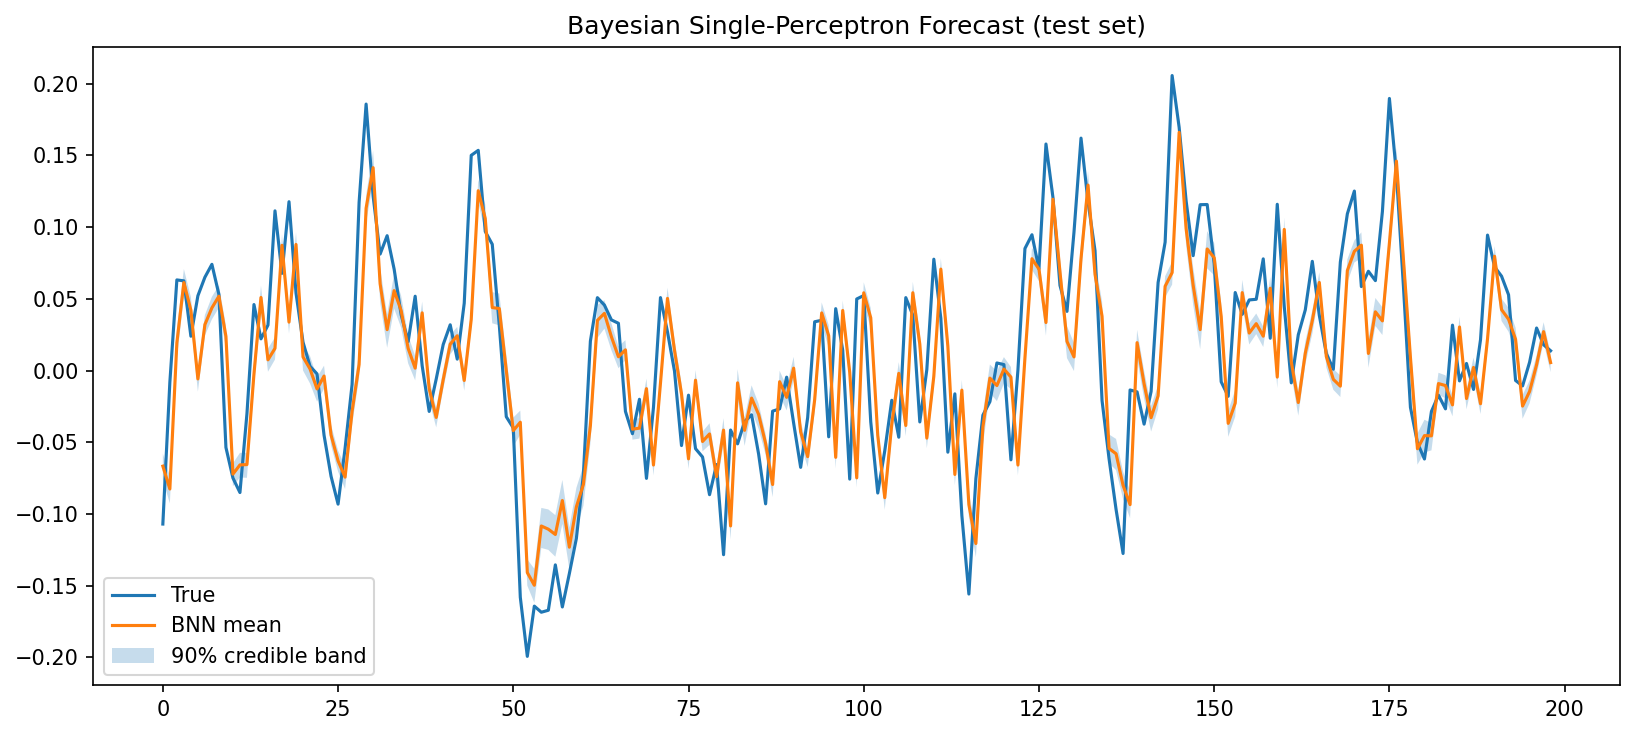

In [18]:
# -------------------------------------------------------
# 6) Posterior predictive: mean and credible intervals
# -------------------------------------------------------
model.eval()
S = 200  # number of posterior samples
with torch.no_grad():
    preds = []
    for _ in range(S):
        y_s, sigma_eps, _ = model(X_test_t, sample=True)
        # draw obs noise if you want full predictive; here we plot latent mean tanh(w^T x + b)
        preds.append(y_s.squeeze().cpu().numpy())
    preds = np.stack(preds, axis=0)  # [S, N_test]
    pred_mean = preds.mean(axis=0)
    pred_lo   = np.quantile(preds, 0.05, axis=0)
    pred_hi   = np.quantile(preds, 0.95, axis=0)
    y_true    = y_test_t.squeeze().cpu().numpy()

plt.figure(figsize=(11,5))
plt.plot(y_true, label="True", linewidth=1.5)
plt.plot(pred_mean, label="BNN mean", linewidth=1.5)
plt.fill_between(np.arange(len(y_true)), pred_lo, pred_hi, alpha=0.25, label="90% credible band")
plt.title("Bayesian Single-Perceptron Forecast (test set)")
plt.legend()
plt.tight_layout()
plt.show()